# NFT交換アプリによるソーシャルネットワークの分析
## 手法
1. 仮想のソーシャルネットワークの生成
    - NFTを渡す
    - NFTを返す
2. 有向グラフから無向グラフへ変換(オーソリティー信用性)
3. 中心性を求める
4. 中心性からスコア順に並べる

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
from random import random
from networkx.algorithms.community import greedy_modularity_communities

## ネットワークデータの用意

In [2]:
# 頂点数：300, 信用できる確率：70%
# データフォーマット(trust：(1：信用できない、0：信用できる)、group：グループ番号1~3)

n = 500
trust_list = list()
group_list = list()

for i in range(1, n+1):
    r = random()
    if r < 0.7:
        trust_list.append(1)
    else:
        trust_list.append(0)

    g = r / 0.25
    group_list.append(int(g) + 1)
        
trust = np.array(trust_list)
group = np.array(group_list)

In [3]:
data = [[] for i in range(n)]
for i, (t, g) in enumerate(zip(trust, group)):
    data[i] = [t, g, 0.0, 0.0, 0.0, 0.0]

In [4]:
df = pd.DataFrame(data=data, columns=["trust", "group", "score", "dc_score", "bc_score", "pr_score"])
print(len(df))
df.head()

500


,trust,group,score,dc_score,bc_score,pr_score
0,1,2,0.0,0.0,0.0,0.0
1,1,3,0.0,0.0,0.0,0.0
2,0,3,0.0,0.0,0.0,0.0
3,1,1,0.0,0.0,0.0,0.0
4,0,3,0.0,0.0,0.0,0.0


## ネットワークの作成

In [5]:
G = nx.DiGraph()
G.add_nodes_from(range(n))
color = ["red", "blue", "green", "yellow"]

## NFTの交換
### NFTを渡す
- グループ内だと5%(NFTを5枚)、グループ外だと1%(NFTを0~1枚)の確立で辺をつなぐ
<!-- - 信頼できる人間同士だと60%、信頼できる or 信頼できない人間だと30%、信頼できない人間同士だと5%の確立で辺をつなぎ返す -->

In [6]:
for myself, myself_row in df.iterrows():
    for target, target_row in df.iterrows():
        p = 0.0
        
        # ループを除く
        if myself == target:
            break

        # 同じグループならNFTを渡す確率を上げる
        if myself_row["group"] == target_row["group"]:
            p = 0.05 
        else:
            p = 0.005

        # 辺をつなぐ
        if random() < p:
            G.add_edge(myself, target)

### NFTを渡した結果を表示

In [7]:
print("頂点数", G.number_of_nodes())
print("辺数", G.number_of_edges())

頂点数 500
辺数 2054


In [8]:
nodes_number = G.number_of_nodes()
color_map = ["black"] * nodes_number
for i in range(nodes_number):
    color_map[i] = color[df.loc[i, "group"]-1]

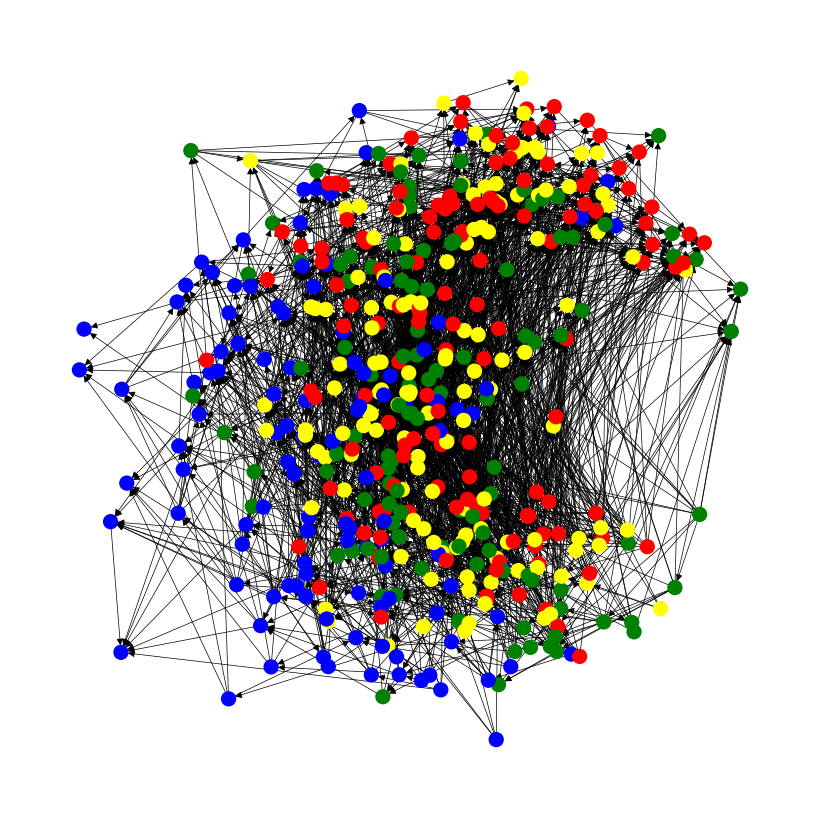

In [9]:
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(G, node_size=100, node_color=color_map, with_labels=False, width=0.5)
plt.savefig("graph1.png")

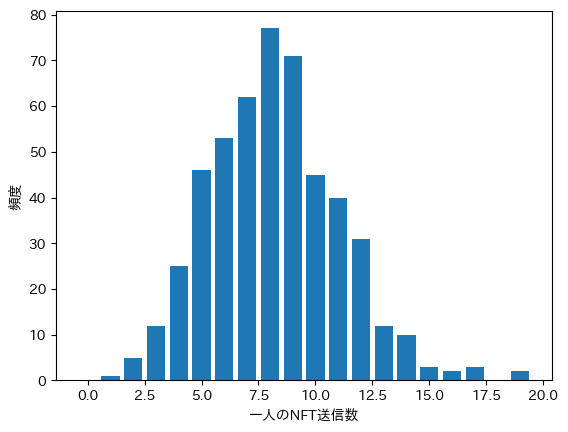

In [10]:
plt.bar(range(len(nx.degree_histogram(G))), height=nx.degree_histogram(G))
plt.xlabel("一人のNFT送信数")
plt.ylabel("頻度")
plt.show()

### NFTを返す(交換に応じる)
- 信用できる人65%、信用できない人35%で応じる
- 場面想定法ではポジティブな情報が一つの場合50%程度から60~65%の信頼できる人を評価する、逆にネガティブな情報の場合は50%から30~35%の確立で評価するように変化する

In [11]:
for edge in G.edges():
    myself = edge[0]
    target = edge[1]
    
    # 信用できる人
    if (df["trust"][target] == 1):
        if random() < 0.65:
            G.add_edge(target, myself)
    # 信用できない人
    else:
        if random() < 0.35:
            G.add_edge(target, myself)

### NFTを返した後の結果の表示

In [12]:
print("頂点数", G.number_of_nodes())
print("辺数", G.number_of_edges())

頂点数 500
辺数 3215


In [13]:
color_map = ["black"] * G.number_of_nodes()
for i in range(G.number_of_nodes()):
    color_map[i] = color[df.loc[i, "group"]-1]

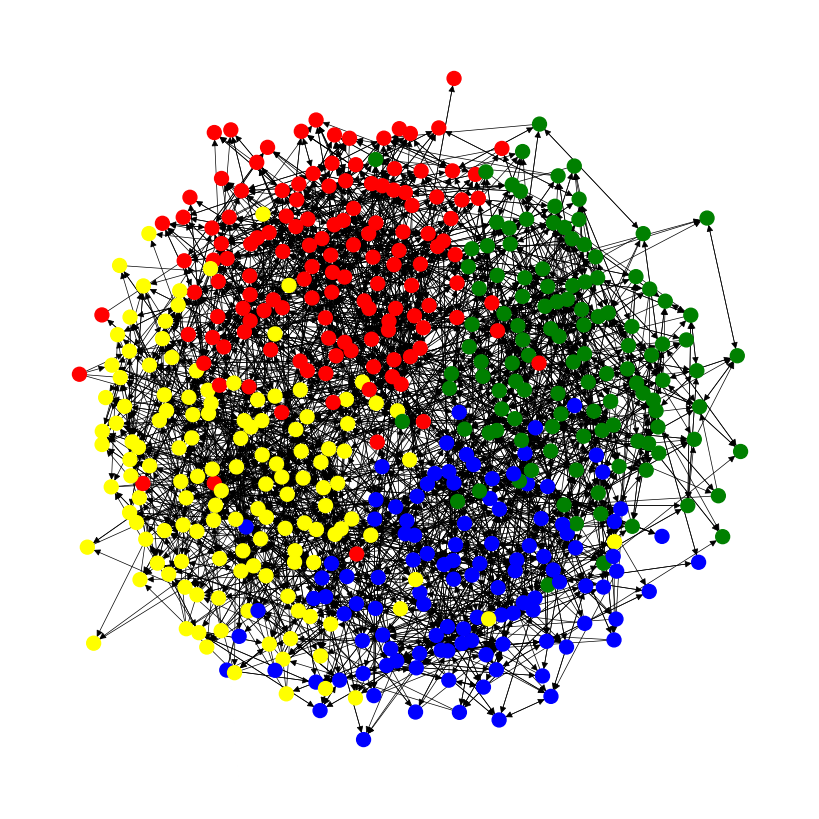

In [14]:
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(G, node_size=100, node_color=color_map, with_labels=False, width=0.5)
plt.savefig("graph2.png")

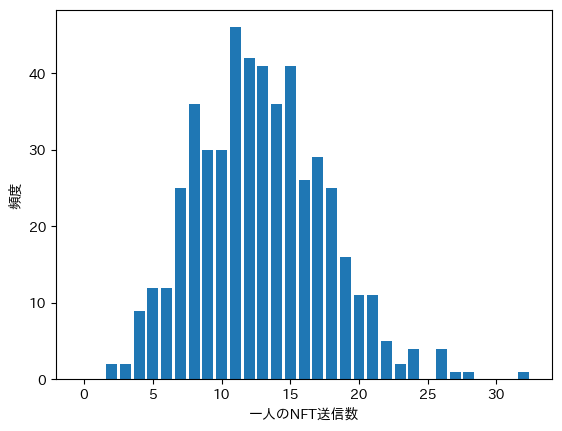

In [15]:
plt.bar(range(len(nx.degree_histogram(G))), height=nx.degree_histogram(G))
plt.xlabel("一人のNFT送信数")
plt.ylabel("頻度")
plt.show()

# ソーシャルグラフからスコアを求める

## 有向グラフから無向グラフへ変換
- オーソリティ中心性を求める

In [16]:
# 隣接行列の作成
A = nx.adjacency_matrix(G).todense()
AT = A.transpose()

In [17]:
# 共引用
GC = nx.DiGraph()
GC.add_nodes_from([i for i in range(n)])
M = np.dot(AT, A)
M = M - np.diag(np.diag(M))
for i, row in enumerate(M):
    for j, n in enumerate(row):
        if(n > 0):
            GC.add_edge(i, j)

In [18]:
color_map_gc = ["black"] * GC.number_of_nodes()
for i in range(GC.number_of_nodes()):
    color_map_gc[i] = color[df.loc[i, "group"]-1]

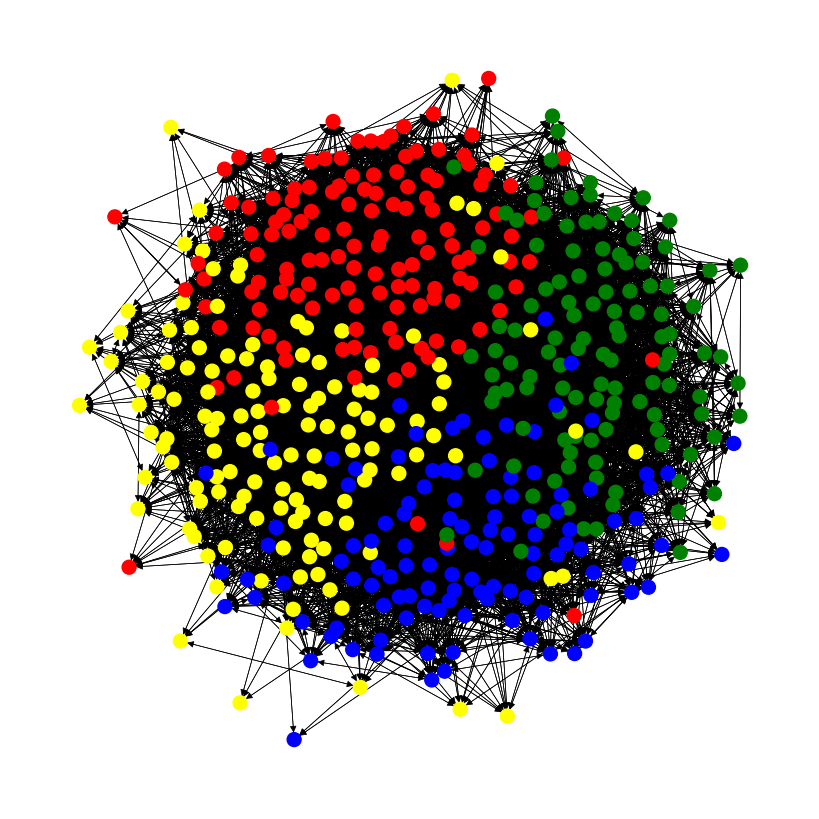

In [19]:
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(GC, node_size=100, node_color=color_map_gc, with_labels=False, width=0.5)
plt.savefig("graph3.png")

In [20]:
print("無向グラフの頂点数：", GC.number_of_nodes())
print("無向グラフの辺数：", GC.number_of_edges())

無向グラフの頂点数： 500
無向グラフの辺数： 19864


## 中心性からスコアを求める
|アルゴリズム名|信用の項目|詳細|
|-------------|-----------|---|
|次元中心性|個別的信用|どれだけ多くの人から信用を受けているのか(ローカル)|
|近傍中心性|×|辺の重みは関係性が低いため|
|媒介中心性|△|経由量は関係性が低いため|
|固有ベクトル中心性|×|多重グラフは利用できないため|
|Katz中心性|×|多重グラフは利用できないため|
|PageRank|個別的信頼|どれだけ多くの人から信用を受けているのか(グローバル)|

In [21]:
def print_centrality(v):
    for key in v:
        print("{:3}：{:<7}".format(key, round(v[key], 5)), end=(" " if (key+1)%5 else "\n"))
    print("")
    print("MAX：", np.argmax(list(v.values())))

def calc_score(v, name):
    temp = np.zeros(len(v))
    for key in v:
        temp[key] = v[key]
    df[name] = temp
    df["score"] += temp

### 次数中心性

In [22]:
v = nx.degree_centrality(GC)
print_centrality(v)
calc_score(v, "dc_score")

  0：0.13226   1：0.10421   2：0.18838   3：0.16834   4：0.27255
  5：0.28858   6：0.1523    7：0.10421   8：0.14028   9：0.08417
 10：0.17635  11：0.16032  12：0.09218  13：0.14429  14：0.19238
 15：0.12024  16：0.18838  17：0.05611  18：0.20842  19：0.18036
 20：0.08818  21：0.17234  22：0.14429  23：0.19238  24：0.08818
 25：0.27255  26：0.23647  27：0.22044  28：0.24449  29：0.2485 
 30：0.18437  31：0.16834  32：0.16433  33：0.2004   34：0.21242
 35：0.12826  36：0.20441  37：0.17234  38：0.11222  39：0.17635
 40：0.17635  41：0.25251  42：0.20441  43：0.20842  44：0.06413
 45：0.21242  46：0.14429  47：0.23647  48：0.27655  49：0.24048
 50：0.12826  51：0.20441  52：0.29659  53：0.21643  54：0.26854
 55：0.17635  56：0.2004   57：0.2004   58：0.16032  59：0.17234
 60：0.27655  61：0.27655  62：0.16032  63：0.20441  64：0.14429
 65：0.2004   66：0.22044  67：0.26052  68：0.18437  69：0.2004 
 70：0.09218  71：0.19238  72：0.07615  73：0.08417  74：0.18838
 75：0.24449  76：0.19639  77：0.08016  78：0.25251  79：0.10822
 80：0.24449  81：0.1483   82：0.16834  83：

### 媒介中心性

In [23]:
v = nx.betweenness_centrality(GC)
print_centrality(v)
calc_score(v, "bc_score")

  0：0.00147   1：0.0006    2：0.00262   3：0.0026    4：0.00588
  5：0.00484   6：0.00159   7：0.00034   8：0.0013    9：0.00042
 10：0.00297  11：0.00237  12：0.00048  13：0.00135  14：0.00182
 15：0.00085  16：0.00301  17：0.00026  18：0.00311  19：0.00229
 20：0.00075  21：0.00174  22：0.00115  23：0.00186  24：0.00054
 25：0.00504  26：0.00451  27：0.0062   28：0.00314  29：0.00376
 30：0.00308  31：0.0018   32：0.00228  33：0.00351  34：0.00256
 35：0.00133  36：0.00333  37：0.00225  38：0.00062  39：0.00183
 40：0.00217  41：0.00517  42：0.00457  43：0.00226  44：0.00018
 45：0.0032   46：0.00089  47：0.00421  48：0.00413  49：0.00396
 50：0.00079  51：0.00273  52：0.00489  53：0.00358  54：0.00751
 55：0.00194  56：0.00244  57：0.00283  58：0.00221  59：0.00179
 60：0.00563  61：0.00661  62：0.0016   63：0.00216  64：0.00139
 65：0.00232  66：0.00378  67：0.00407  68：0.00144  69：0.00203
 70：0.00035  71：0.00213  72：0.00023  73：0.00032  74：0.00185
 75：0.00409  76：0.0028   77：0.00037  78：0.00379  79：0.00071
 80：0.00383  81：0.00193  82：0.00297  83：

### PageRank

In [24]:
v = nx.pagerank(GC, max_iter=1000)
print_centrality(v)
calc_score(v, "pr_score")

  0：0.00176   1：0.00143   2：0.00232   3：0.00212   4：0.00325
  5：0.00329   6：0.00194   7：0.0014    8：0.00178   9：0.00123
 10：0.00222  11：0.00206  12：0.00128  13：0.00182  14：0.00228
 15：0.00161  16：0.00235  17：0.00091  18：0.0025   19：0.00226
 20：0.00127  21：0.00211  22：0.00183  23：0.0023   24：0.00125
 25：0.00315  26：0.00282  27：0.00279  28：0.00283  29：0.0029 
 30：0.0023   31：0.00207  32：0.00207  33：0.00247  34：0.00251
 35：0.00169  36：0.00251  37：0.00217  38：0.00149  39：0.00219
 40：0.00216  41：0.003    42：0.00256  43：0.00249  44：0.00102
 45：0.00255  46：0.00183  47：0.00282  48：0.00316  49：0.00283
 50：0.00165  51：0.00248  52：0.0034   53：0.00262  54：0.00329
 55：0.00218  56：0.00244  57：0.00247  58：0.002    59：0.00212
 60：0.00326  61：0.00326  62：0.00202  63：0.00244  64：0.00183
 65：0.00238  66：0.00265  67：0.00304  68：0.00221  69：0.00239
 70：0.00125  71：0.00234  72：0.00113  73：0.00118  74：0.00232
 75：0.00287  76：0.00241  77：0.00121  78：0.00293  79：0.00145
 80：0.00287  81：0.00192  82：0.00223  83：

## 最終結果
- スコア順に並びかえて先頭60人が信用できる人であった割合

In [25]:
count = 0
for index, row in df.iterrows():
    if row["trust"] == 1:
        count += 1
print("信頼できる", count, "信頼できない", len(df) - count)

信頼できる 338 信頼できない 162


### スコアなし(ソートせずに取り出す)

In [26]:
count = 0
for index, row in df.head(50).iterrows():
    if row["trust"] == 1:
        count += 1
print("正解率", count / 50.0 * 100.0, "%")

正解率 66.0 %


### 次元中心性を用いたスコアリング

In [27]:
sorted_df = df.sort_values("dc_score", ascending=False)
count = 0
for index, row in sorted_df.head(50).iterrows():
    if row["trust"] == 1:
        count += 1

print("正解率", count / 50.0 * 100.0, "%")
sorted_df.head(10)

正解率 70.0 %


,trust,group,score,dc_score,bc_score,pr_score
83,1,1,0.401649,0.388778,0.008545,0.004327
202,0,4,0.379133,0.364729,0.010222,0.004181
256,1,1,0.360212,0.348697,0.007595,0.003920
226,0,4,0.349494,0.336673,0.008929,0.003892
443,1,1,0.342973,0.332665,0.006559,0.003749
186,0,4,0.334573,0.320641,0.010073,0.003859
214,1,1,0.331114,0.320641,0.006839,0.003634
180,0,4,0.332366,0.320641,0.007987,0.003738
344,1,1,0.327499,0.316633,0.007218,0.003647
121,1,1,0.328654,0.316633,0.008339,0.003682


### 媒介中心性を用いたスコアリング

In [28]:
sorted_df = df.sort_values("bc_score", ascending=False)
count = 0
for index, row in sorted_df.head(50).iterrows():
    if row["trust"] == 1:
        count += 1

print("正解率", count / 50.0 * 100.0, "%")
sorted_df.head(10)

正解率 64.0 %


,trust,group,score,dc_score,bc_score,pr_score
202,0,4,0.379133,0.364729,0.010222,0.004181
186,0,4,0.334573,0.320641,0.010073,0.003859
457,1,1,0.305176,0.292585,0.009074,0.003517
226,0,4,0.349494,0.336673,0.008929,0.003892
183,0,4,0.325041,0.312625,0.008721,0.003694
83,1,1,0.401649,0.388778,0.008545,0.004327
146,0,4,0.300552,0.288577,0.008540,0.003434
116,1,2,0.312592,0.300601,0.008419,0.003572
121,1,1,0.328654,0.316633,0.008339,0.003682
180,0,4,0.332366,0.320641,0.007987,0.003738


### PageRankを用いたスコアリング

In [29]:
sorted_df = df.sort_values("pr_score", ascending=False)
count = 0
for index, row in sorted_df.head(50).iterrows():
    if row["trust"] == 1:
        count += 1

print("正解率", count / 50.0 * 100.0, "%")
sorted_df.head(10)

正解率 68.0 %


,trust,group,score,dc_score,bc_score,pr_score
83,1,1,0.401649,0.388778,0.008545,0.004327
202,0,4,0.379133,0.364729,0.010222,0.004181
256,1,1,0.360212,0.348697,0.007595,0.003920
226,0,4,0.349494,0.336673,0.008929,0.003892
186,0,4,0.334573,0.320641,0.010073,0.003859
443,1,1,0.342973,0.332665,0.006559,0.003749
180,0,4,0.332366,0.320641,0.007987,0.003738
183,0,4,0.325041,0.312625,0.008721,0.003694
121,1,1,0.328654,0.316633,0.008339,0.003682
344,1,1,0.327499,0.316633,0.007218,0.003647


### 中心性(和)を用いたスコアリング

In [30]:
sorted_df = df.sort_values("score", ascending=False)
count = 0
for index, row in sorted_df.head(50).iterrows():
    if row["trust"] == 1:
        count += 1

print("正解率", count / 50.0 * 100.0, "%")
sorted_df.head(10)

正解率 70.0 %


,trust,group,score,dc_score,bc_score,pr_score
83,1,1,0.401649,0.388778,0.008545,0.004327
202,0,4,0.379133,0.364729,0.010222,0.004181
256,1,1,0.360212,0.348697,0.007595,0.003920
226,0,4,0.349494,0.336673,0.008929,0.003892
443,1,1,0.342973,0.332665,0.006559,0.003749
186,0,4,0.334573,0.320641,0.010073,0.003859
180,0,4,0.332366,0.320641,0.007987,0.003738
214,1,1,0.331114,0.320641,0.006839,0.003634
121,1,1,0.328654,0.316633,0.008339,0.003682
344,1,1,0.327499,0.316633,0.007218,0.003647


## グループの抽出

In [31]:
color = ["red", "orange", "yellow", "green", "blue", "purple", "gray"]
lst_m = greedy_modularity_communities(G)
color_map_m = ["black"] * G.number_of_nodes()
for counter, c in enumerate(lst_m):
    for n in c:
        try:
            color_map_m[n] = color[counter]
        except:
            color_map_m[n] = color_map_m[n]

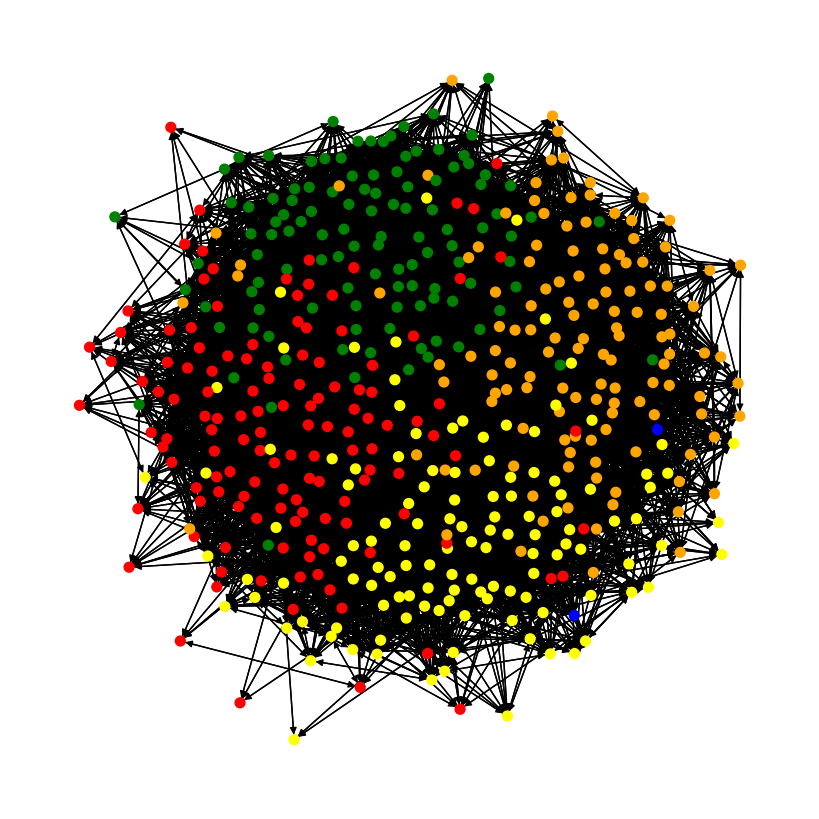

In [32]:
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(GC, node_size=50, node_color=color_map_m)